# Bayes Cluster Expansion
### Author Peichen Zhong

In [1]:
import numpy as np
from smol.cofe import ClusterExpansion, RegressionData
from smol.io import load_work
from theorytoolkit.optimization.ce_Bayes_opt import *
from theorytoolkit.optimization.adds_on import *

# Load a cluster expansion file from previous saved one

In [2]:
work = load_work('../data/lmto_sinusoid.mson')
for name, obj in work.items():
    print(f'{name}: {type(obj)}\n')

StructureWrangler: <class 'smol.cofe.wrangling.wrangler.StructureWrangler'>

ClusterExpansion: <class 'smol.cofe.expansion.ClusterExpansion'>



In [3]:
wrangler = work['StructureWrangler']
ce = work['ClusterExpansion']

#  Training part

Training a cluster expansion is one of the most critical steps. 

Training with Bayesian regression typically requires the correlation vector to be represented in orthogonal basis.
Indicator basis is not appropriate for Bayesian regression

In [4]:
wrangler.feature_matrix.shape

(630, 27)

# Optimization of ridge regularization in Li-Mn-Ti-O system

In [5]:
coefs_ridge = ridge_optimize(
    A=wrangler.feature_matrix, 
    f=wrangler.get_property_vector('total_energy'), 
    mu=1e-4)

print(coefs_ridge)

[-11.92439872   4.68735753  -0.23787396   0.74980824  -0.46459773
   0.14105951   0.43117229  -0.19676567   0.0542778    0.18090402
   0.19251365  -0.11920026   0.13823426   0.07085491  -0.03708378
   0.23008805  -0.11591784  -0.01576551  -0.26739028  -0.06974138
   0.44250468   0.06094559  -0.07070943  -0.09513262   0.28059894
   0.1189496   -0.11077483]


# Optimization of Bayesian regularization in Li-Mn-Ti-O system

In [6]:
opt_gamma, regu = get_optimal_gamma(subspace=ce.cluster_subspace, 
                                    A=wrangler.feature_matrix, 
                                    f= wrangler.get_property_vector('total_energy'),
                                    if_Ewald= False)

cov = np.diag(regu)

In [7]:
cov.shape

(27, 27)

In [8]:
wrangler.feature_matrix.shape

(630, 27)

In [9]:
coefs_Bayes = Bayes_optimize(A=wrangler.feature_matrix, 
                   f= wrangler.get_property_vector('total_energy'), 
                   cov = cov)

print(coefs_Bayes)

[-1.25040205e+01  3.22392683e+00  3.41565513e-01  8.02704723e-01
 -2.84795487e-01  1.18788948e-02  4.17343382e-01 -1.85998753e-01
  5.36182502e-02  1.52883253e-01  2.08307588e-01 -1.23896961e-01
  1.30504228e-01  7.90317686e-02 -4.76187594e-02  2.05094443e-01
 -8.54556269e-02 -1.88612051e-02 -1.98668701e-01  9.95106027e-02
  1.39735927e-01  1.21256886e-02 -5.00197735e-02 -3.49013485e-02
  1.01629257e-01  5.11382017e-02  1.95112931e-02]


# Comparison of ridge and Bayesian regression in Li-Mn-Ti-O system

Non-zero ECIs in ridge:  27
Non-zero ECIs in Bayesian:  27


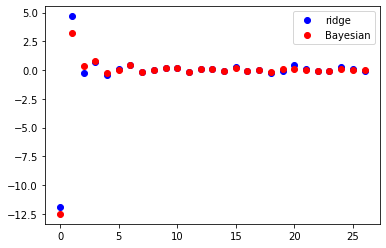

In [10]:
plt.plot(coefs_ridge, 'o', color = 'b',label = 'ridge')
plt.plot(coefs_Bayes, 'o',color = 'r', label = 'Bayesian')
plt.legend()


print("Non-zero ECIs in ridge: ", np.sum(np.abs(coefs_ridge)>1e-6))
print("Non-zero ECIs in Bayesian: ", np.sum(np.abs(coefs_Bayes)>1e-6))

### 4) Create a cluster expansion

In [11]:
reg_data = RegressionData.from_object(
    Bayes_optimize, feature_matrix=wrangler.feature_matrix,
    property_vector=wrangler.get_property_vector('total_energy'),
    parameters={'cov': cov})
expansion = ClusterExpansion(
    ce.cluster_subspace, coefficients=coefs_Bayes,
    regression_data=reg_data)

rng = np.random.default_rng()
structure = rng.choice(wrangler.structures)
prediction = expansion.predict(structure, normalize=True)

print(f'The predicted energy for a structure with composition '
      f'{structure.composition} is {prediction} eV/prim.\n')
print(f'The fitted coefficients are:\n{expansion.coefs}\n')
print(f'The effective cluster interactions are:\n{expansion.eci}\n')
print(expansion)

The predicted energy for a structure with composition Mn3+4 Li+4 O2-8 is -13.11411388209557 eV/prim.

The fitted coefficients are:
[-1.25040205e+01  3.22392683e+00  3.41565513e-01  8.02704723e-01
 -2.84795487e-01  1.18788948e-02  4.17343382e-01 -1.85998753e-01
  5.36182502e-02  1.52883253e-01  2.08307588e-01 -1.23896961e-01
  1.30504228e-01  7.90317686e-02 -4.76187594e-02  2.05094443e-01
 -8.54556269e-02 -1.88612051e-02 -1.98668701e-01  9.95106027e-02
  1.39735927e-01  1.21256886e-02 -5.00197735e-02 -3.49013485e-02
  1.01629257e-01  5.11382017e-02  1.95112931e-02]

The effective cluster interactions are:
[-1.25040205e+01  3.22392683e+00  3.41565513e-01  1.33784120e-01
 -2.37329573e-02  1.97981581e-03  1.39114461e-01 -3.09997922e-02
  1.78727501e-02  1.27402711e-02  8.67948282e-03 -1.03247468e-02
  2.17507047e-02  6.58598072e-03 -7.93645989e-03  1.70912036e-02
 -3.56065112e-03 -1.57176710e-03 -2.48335877e-02  4.14627511e-03
  5.82233029e-03  1.51571108e-03 -2.50098867e-02 -4.36266857e-0

/tmp/ipykernel_296459/1990728918.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  structure = np.random.choice(wrangler.structures)
